In [1]:
%load_ext autoreload
%autoreload 2

import multiprocessing as mp
import torch
import wandb_util.wandb_util as wbu
from scripts.wandb_experiments.comparison_exp import multidim_sweep_exp

torch.set_grad_enabled(False)
mp.set_start_method("spawn", force=True)

In [ ]:
from scripts.wandb_experiments.comparison_exp import MultiDimSweepConfig
from scripts.wandb_runs.run_grtex import RunGrTexConfig, run_gr_tex
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.pipelines.pipeline_utils import ModelConfig
from omegaconf import OmegaConf

from text3d2video.utilities.omegaconf_util import get_import_path

prompt = "Lion"
extr_tag = "lion_zoom_out_srclatest_Lion_0:v0"
tgt_tag = "lion_zoom:latest"

# prompt = "Stormtrooper"
# extr_tag = 'rumba_zoom_out_srclatest_Stormtrooper_0:v0'
# tgt_tag = 'rumba_zoom_20:latest'

base_config = OmegaConf.structured(
    RunGrTexConfig(
        prompt=prompt,
        animation_tag=tgt_tag,
        extr_tag=extr_tag,
        generative_rendering=GenerativeRenderingConfig(feature_blend_alpha=0.7),
        model=ModelConfig(),
        start_noise_level=0.2,
        seed=0,
    )
)

overrides = [{'multires_textures': b} for b in [False, True]]
labels = ["No Multires Textures", "Multires Textures"]

override_dims = [overrides]
override_dim_labels = [labels]

sweep_config = OmegaConf.structured(MultiDimSweepConfig(
    fun_path=get_import_path(run_gr_tex),
    base_config=base_config,
    override_dims=override_dims,
    override_dim_labels=override_dim_labels,
))

spec = multidim_sweep_exp(sweep_config)
spec

[No Multires Textures([]), Multires Textures([])]

In [8]:
wbu.sync_experiment(multidim_sweep_exp, sweep_config, "multires_ablation")

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/multires_ablation/workspace
Experiment up-to-date!


In [15]:
from text3d2video.util import group_into_array

exp_name = "multires_ablation"

runs = wbu.get_logged_runs(exp_name)

def label_key(run):
    config: RunGrTexConfig = OmegaConf.create(run.config)

    if config.multires_textures:
        return "Multires Textures"
    elif config.multires_textures is False:
        return "No Multires Textures"

runs_grouped, labels = group_into_array(runs, [label_key])
labels = labels[0]

In [16]:
from text3d2video.experiment_analysis import VideoTraces
from text3d2video.util import map_array

run_traces = map_array(runs_grouped, VideoTraces.from_run, pbar=True)

wandb:   20 of 20 files downloaded.  wandb: \ 1 of 20 files downloaded...
100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


In [17]:
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

vids = map_array(run_traces, lambda x: pil_frames_to_clip(x.frames), pbar=True)

display_vids(vids, titles=labels)

100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


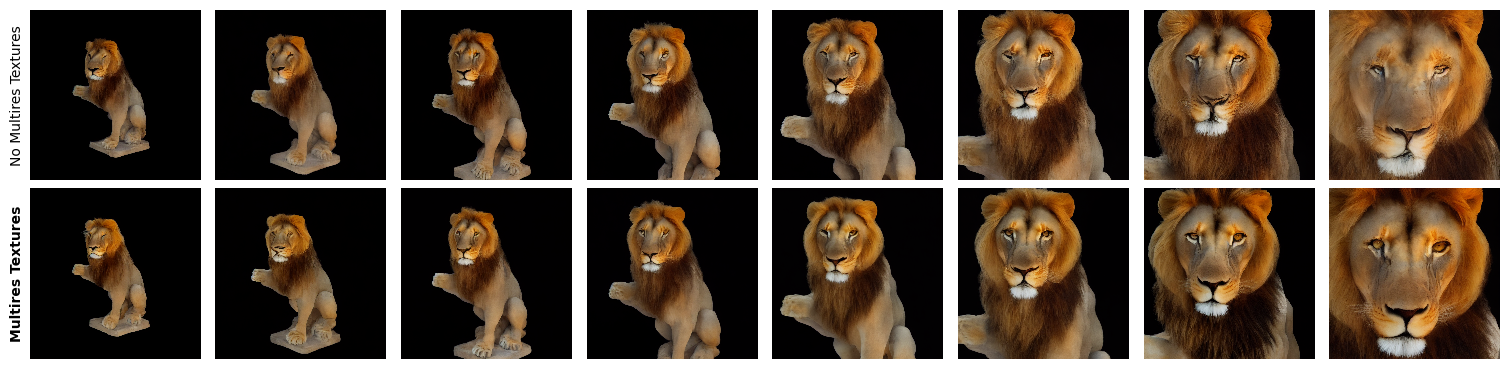

In [34]:
from matplotlib import pyplot as plt
from text3d2video.util import index_list, map_object_array, object_array, ordered_sample_indices
from text3d2video.utilities.ipython_utils import display_ims_grid


frame_indices = list(ordered_sample_indices(list(range(20)), 8))
ims = map_object_array(
    run_traces, lambda x: object_array(index_list(x.frames, frame_indices))
)

order = [1, 0]
ims = ims[order]
fig_labels = index_list(labels, order)

fig, axs = display_ims_grid(ims, row_titles=fig_labels, scale=1.9, show=False)
axs[-1, 0].set_ylabel("Multires Textures", fontweight="bold")

plt.savefig("outs/multires_ablation.pdf", bbox_inches="tight", dpi=300)